In [1]:
import sagemaker
from sagemaker.pytorch import PyTorchModel
import torch, torchvision

In [2]:
# Load DenseNet121 model from torchvision with pretrained weights
model = torchvision.models.densenet121(pretrained=True).eval()

In [3]:
scripted_model = torch.jit.script(model)

In [4]:
# Serialize model to file
torch.jit.save(scripted_model, 'model.pt')

In [5]:
!tar -czvf densenet121.tar.gz model.pt

model.pt


In [6]:
# Upload data to S3
sagemaker_session = sagemaker.Session()
tar_filename = 'densenet121.tar.gz'
model_data_s3_path = sagemaker_session.upload_data(path=tar_filename)

In [7]:
torch.__version__

'1.10.0'

In [83]:
# Let's try a very simple model, to verify things are working
# Note: model.pt is completely ignored by this model entrypoint's model_fn
import time
timestwo_model_name = "mmsv2-timestwo-pytorch-example"
timestwo_timestamped_model_name = timestwo_model_name+time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
role = sagemaker.get_execution_role()
timestwo_model = PyTorchModel(framework_version=str(torch.__version__),
                     py_version='py38',
                     image_uri="301217895009.dkr.ecr.us-west-2.amazonaws.com/sagemaker-mmsv2:2.0.0-cpu-py38-ubuntu20.04",
                     env={'MMS_LOG_LEVEL':'1', 'MMS_USE_FRAMEWORK':'PT'},
                     model_data=model_data_s3_path,
                     role=role,
                     source_dir="code",
                     entry_point="times2model.py",
                     #predictor_cls=Predictor,
                     name=timestwo_timestamped_model_name)

timestwo_instance_type = 'ml.c5.2xlarge' # 'local' for local mode
timestwo_endpoint_name = timestwo_model_name+time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
timestwo_predictor = timestwo_model.deploy(endpoint_name=timestwo_endpoint_name,
                         initial_instance_count=1,
                         instance_type=timestwo_instance_type)


-------!

In [84]:
timestwo_predictor.predict([1, 2, 3, 4, 5])

array([ 2,  4,  6,  8, 10])

In [95]:
import time
ts_timestwo_model_name = "ts-timestwo-pytorch-example"
ts_timestwo_timestamped_model_name = ts_timestwo_model_name+time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
role = sagemaker.get_execution_role()
ts_timestwo_model = PyTorchModel(framework_version=str(torch.__version__),
                     py_version='py38',
                     model_data=model_data_s3_path,
                     role=role,
                     source_dir="code",
                     entry_point="times2model.py",
                     #predictor_cls=Predictor,
                     name=ts_timestwo_timestamped_model_name)

ts_timestwo_instance_type = 'ml.c5.2xlarge' # 'local' for local mode
ts_timestwo_endpoint_name = ts_timestwo_model_name+time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
ts_timestwo_predictor = ts_timestwo_model.deploy(endpoint_name=ts_timestwo_endpoint_name,
                         initial_instance_count=1,
                         instance_type=ts_timestwo_instance_type)

------!

In [96]:
ts_timestwo_predictor.predict([1, 2, 3, 4, 5])

array([ 2,  4,  6,  8, 10])

In [82]:
import time
model_name = "densenet-pytorch-example"
timestamped_model_name = model_name+time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
role = sagemaker.get_execution_role()
model = PyTorchModel(framework_version=str(torch.__version__),
                     py_version='py38',
                     image_uri="301217895009.dkr.ecr.us-west-2.amazonaws.com/sagemaker-mmsv2:2.0.0-cpu-py38-ubuntu20.04",
                     env={'MMS_LOG_LEVEL':'1', 'MMS_USE_FRAMEWORK':'PT'},
                     model_data=model_data_s3_path,
                     role=role,
                     source_dir="code",
                     entry_point="inference.py",
                     #predictor_cls=Predictor,
                     name=timestamped_model_name)


In [49]:
model.name

'densenet-pytorch-example-2022-07-18-22-03-49'

In [50]:
model_data_s3_path

's3://sagemaker-us-west-2-332286793603/data/densenet121.tar.gz'

In [ ]:
instance_type = 'ml.g4dn.2xlarge' # 'local' for local mode
endpoint_name = model_name+time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
predictor = model.deploy(endpoint_name=endpoint_name,
                         initial_instance_count=1,
                         instance_type=instance_type)


Using already existing model: densenet-pytorch-example-2022-07-18-22-03-49


-----

In [22]:
# Let's get an image to classify
import torchvision.transforms as transforms
import PIL
from PIL import Image

def transform_image(image):
  # ImageNet pretrained models required input images to have width/height of 224
  # and color channels normalized according to ImageNet distribution.
  image_process = transforms.Compose([transforms.Resize([224, 224]),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])])
  transformed_image = image_process(image) # 3 x 224 x 224
  return transformed_image.unsqueeze(0) # Add dimension to become 1 x 3 x 224 x 224

image = Image.open('shiba.jpg')
image_input = transform_image(image)

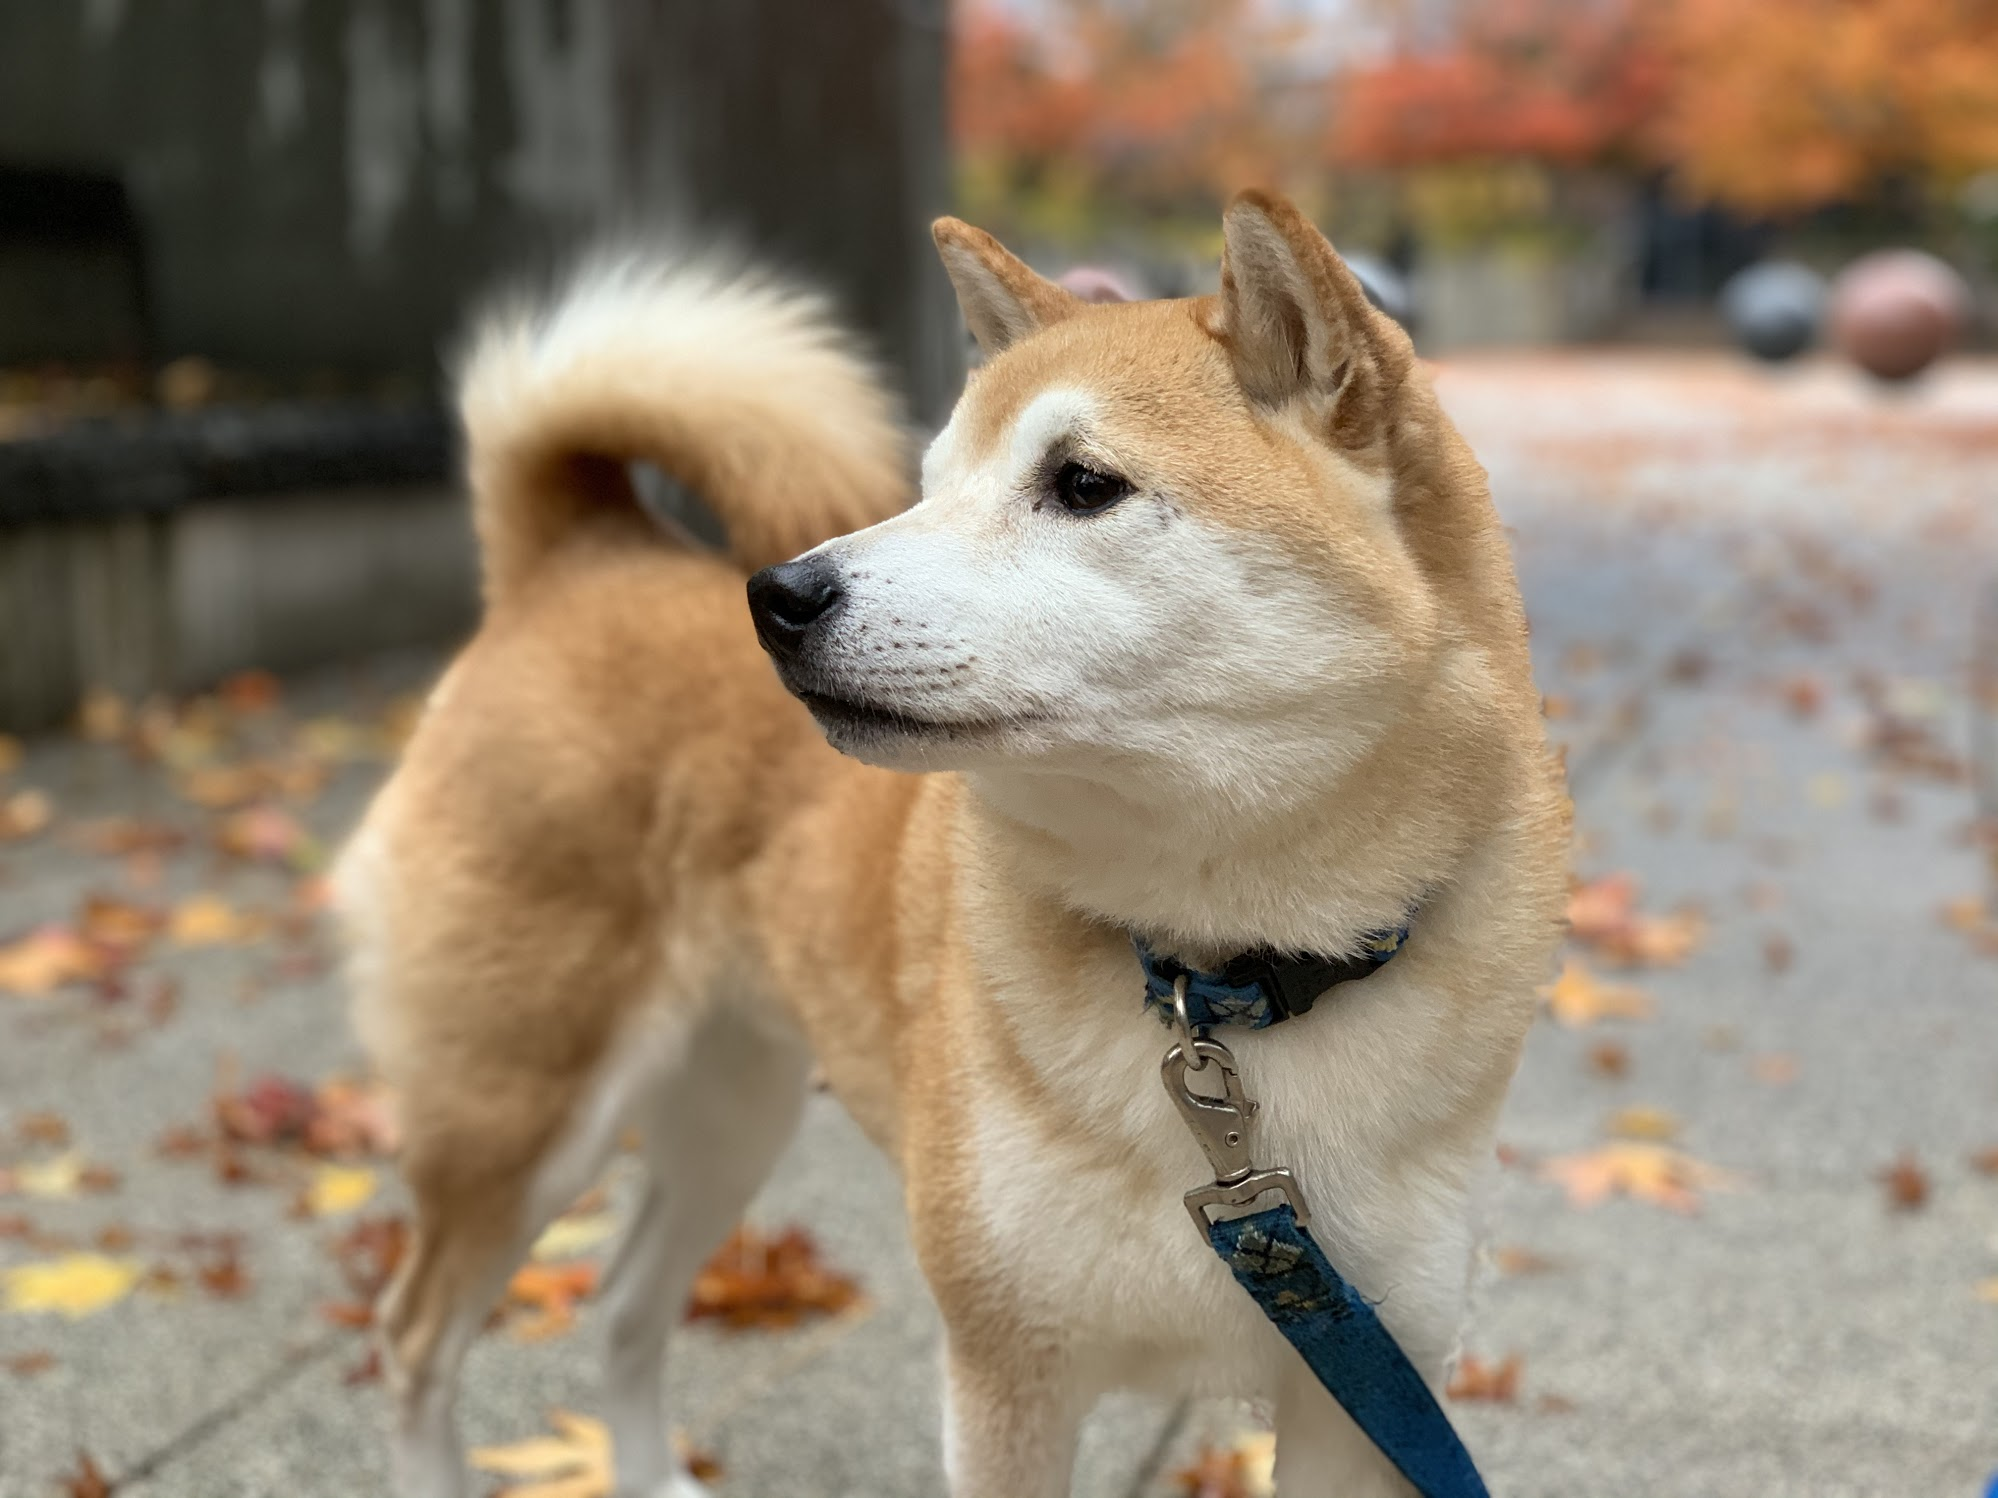

In [23]:
image

In [30]:
classes = eval(open('imagenet_classes.txt').read())

In [31]:
def print_top_5(probs):
    # Print the top 5 classes with probabilities
    pred_probs, pred_indices = torch.topk(probs, 5)
    pred_probs = pred_probs.squeeze().numpy()
    pred_indices = pred_indices.squeeze().numpy()

    for i in range(len(pred_indices)):
      curr_class = classes[pred_indices[i]]
      curr_prob = pred_probs[i]
      print('{}: {:.4f}'.format(curr_class, curr_prob))

In [67]:
output = predictor.predict(image_input)
probs = torch.nn.Softmax(dim=1)(torch.from_numpy(output))

In [68]:
print_top_5(probs)

Eskimo dog, husky: 0.5998
Siberian husky: 0.1559
Norwegian elkhound, elkhound: 0.0796
dingo, warrigal, warragal, Canis dingo: 0.0664
basenji: 0.0229


In [ ]:
import time
ts_model_name = "ts-densenet-pytorch-example"
ts_timestamped_model_name = ts_model_name+time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
role = sagemaker.get_execution_role()
ts_model = PyTorchModel(framework_version=str(torch.__version__),
                     py_version='py38',
                     model_data=model_data_s3_path,
                     role=role,
                     source_dir="code",
                     entry_point="inference.py",
                     #predictor_cls=Predictor,
                     name=ts_timestamped_model_name)

ts_instance_type = 'ml.g4dn.2xlarge' # 'local' for local mode
ts_endpoint_name = ts_model_name+time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
ts_predictor = ts_model.deploy(endpoint_name=ts_endpoint_name,
                         initial_instance_count=1,
                         instance_type=ts_instance_type)


------!

In [35]:
ts_output = ts_predictor.predict(image_input)

ts_probs = torch.nn.Softmax(dim=1)(torch.from_numpy(ts_output))

In [36]:
print_top_5(ts_probs)

Eskimo dog, husky: 0.5998
Siberian husky: 0.1559
Norwegian elkhound, elkhound: 0.0796
dingo, warrigal, warragal, Canis dingo: 0.0664
basenji: 0.0229


In [74]:
import time, datetime

def run_inferences(predictor, image_input, n):
    for i in range(n):
        output = predictor.predict(image_input)
    
def benchmark_predictor(predictor, image_input, warmup=True):
    if warmup:
        # Run 100 warmup inferences so we can print some latency metrics
        run_inferences(predictor, image_input, 100)
        # Wait a bit to keep defined boundaries for CloudWatch
        time.sleep(60)

    # Gather statistics for the next 1000 inferences
    cw_start = datetime.datetime.utcnow()

    time.sleep(5)

    for i in range(1000):
        output = predictor.predict(image_input)

    cw_end = datetime.datetime.utcnow()
    cw_end += datetime.timedelta(minutes=5)
    
    return cw_start, cw_end

In [38]:
import boto3
import math
def get_cloudwatch_latency_metrics(endpoint_name, cw_start, cw_end):
    cloudwatch = boto3.client('cloudwatch')
    statistics=['SampleCount', 'Average', 'Minimum', 'Maximum']
    extended=['p50', 'p90', 'p95']
    
    # Period must be 1, 5, 10, 30, or multiple of 60
    # Calculate closest multiple of 60 to the total elapsed time
    factor = math.ceil((cw_end - cw_start).total_seconds() / 60)
    period = factor * 60
    print('Time elapsed: {} seconds'.format((cw_end - cw_start).total_seconds()))
    print('Using period of {} seconds\n'.format(period))
    model_latency_metrics = cloudwatch.get_metric_statistics(MetricName='ModelLatency',
                                             Dimensions=[{'Name': 'EndpointName',
                                                          'Value': endpoint_name},
                                                         {'Name': 'VariantName',
                                                          'Value': "AllTraffic"}],
                                             Namespace="AWS/SageMaker",
                                             StartTime=cw_start,
                                             EndTime=cw_end,
                                             Period=period,
                                             Statistics=statistics,
                                             ExtendedStatistics=extended
                                             )
    return model_latency_metrics

def print_cloudwatch_latency_metrics(model_latency_metrics):
    if len(model_latency_metrics['Datapoints']) > 0:
        print('{} latency datapoints ready'.format(int(model_latency_metrics['Datapoints'][0]['SampleCount'])))
        print('Side-car latency percentiles:')
        side_avg = model_latency_metrics['Datapoints'][0]['Average'] / 1000
        side_p50 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p50'] / 1000
        side_p90 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p90'] / 1000
        print('   Avg   |   P50   |   P90')
        print(' {:.4f} | {:.4f} | {:.4f}\n'.format(side_avg, side_p50, side_p90))

In [75]:
ts_cw_start, ts_cw_end = benchmark_predictor(ts_predictor, image_input, warmup=False)

In [77]:
ts_cw_end

datetime.datetime(2022, 7, 19, 15, 46, 28, 754229)

In [78]:
ts_metrics = get_cloudwatch_latency_metrics(ts_endpoint_name, ts_cw_start, ts_cw_end)
print_cloudwatch_latency_metrics(ts_metrics)

Time elapsed: 338.199556 seconds
Using period of 360 seconds

1000 latency datapoints ready
Side-car latency percentiles:
   Avg   |   P50   |   P90
 20.6458 | 20.8215 | 22.0596



In [79]:
cw_start, cw_end = benchmark_predictor(predictor, image_input, warmup=False)

In [80]:
cw_end

datetime.datetime(2022, 7, 19, 15, 56, 40, 449713)

In [81]:
mmsv2_metrics = get_cloudwatch_latency_metrics(endpoint_name, cw_start, cw_end)
print_cloudwatch_latency_metrics(mmsv2_metrics)

Time elapsed: 335.666832 seconds
Using period of 360 seconds

1000 latency datapoints ready
Side-car latency percentiles:
   Avg   |   P50   |   P90
 17.9097 | 17.6580 | 18.6331



In [85]:
# Benchmark timestwo_predictor just for kicks
run_inferences(timestwo_predictor, [1, 2, 3, 4, 5], 100)


In [92]:
timestwo_mmsv2_start, timestwo_mmsv2_end = benchmark_predictor(timestwo_predictor, [1, 2, 3, 4, 5], warmup=False)

In [93]:
timestwo_mmsv2_start, timestwo_mmsv2_end

(datetime.datetime(2022, 7, 19, 17, 27, 55, 142555),
 datetime.datetime(2022, 7, 19, 17, 33, 5, 764954))

In [94]:
timestwo_mmsv2_metrics = get_cloudwatch_latency_metrics(timestwo_mmsv2_endpoint_name, timestwo_mmsv2_start, timestwo_mmsv2_end)
print_cloudwatch_latency_metrics(timestwo_mmsv2_metrics)

Time elapsed: 310.622399 seconds
Using period of 360 seconds

1000 latency datapoints ready
Side-car latency percentiles:
   Avg   |   P50   |   P90
 0.6794 | 0.6122 | 0.9508



In [97]:
# Benchmark ts_timestwo_predictor to compare
run_inferences(ts_timestwo_predictor, [1, 2, 3, 4, 5], 100)

In [98]:
ts_timestwo_start, ts_timestwo_end = benchmark_predictor(ts_timestwo_predictor, [1, 2, 3, 4, 5], warmup=False)

In [102]:
ts_timestwo_start, ts_timestwo_end

(datetime.datetime(2022, 7, 19, 17, 41, 9, 169181),
 datetime.datetime(2022, 7, 19, 17, 46, 20, 826260))

In [105]:
ts_timestwo_metrics = get_cloudwatch_latency_metrics(ts_timestwo_endpoint_name, ts_timestwo_start, ts_timestwo_end)
print_cloudwatch_latency_metrics(ts_timestwo_metrics)

Time elapsed: 311.657079 seconds
Using period of 360 seconds

1000 latency datapoints ready
Side-car latency percentiles:
   Avg   |   P50   |   P90
 1.2501 | 1.1662 | 1.6170

